# **Stroke Prediction**

In [1]:
#Feature Encoding
def one_hot_encoding(train_data,test_data,cols_name) :
    from sklearn.preprocessing import OneHotEncoder
    encoded_features = []
    for df in [train_data, test_data]:
        cnt = 0
        for feature in cols_name:
            encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
            n = df[feature].nunique()
            cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
            encoded_df = pd.DataFrame(encoded_feat, columns=cols)
            encoded_df.index = df.index
            encoded_features.append(encoded_df)
            cnt += 1
    train_X = pd.concat([train_data, *encoded_features[:cnt]], axis=1)
    test_X = pd.concat([test_data, *encoded_features[cnt:]], axis=1)
    return train_X, test_X

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from math import exp
from random import seed
from random import random

# create NeuralNetwork class
class NeuralNetwork:

  # intialize variables in class
  def __init__(self):
    self.network = []

  # Initialize a network
  def initialize_network(self, n_inputs, n_hidden, n_outputs):
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    self.network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    self.network.append(output_layer)
  
  # Calculate neuron activation for an input
  def activate(self, weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
      activation += (weights[i] * inputs[i])
    return activation 

  # Forward propagate input to a network output
  def forward_propagate(self, row):
    inputs = row
    for layer in self.network:
      new_inputs = []
      for neuron in layer:
        activation = self.activate(neuron['weights'], inputs)
        neuron['output'] = 1.0 / (1.0 + exp(-activation))
        new_inputs.append(neuron['output'])
      inputs = new_inputs
    return inputs

  # Calculate the derivative of an neuron output
  def transfer_derivative(self, output):
    return output * (1.0 - output)

  # Backpropagate error and store in neurons
  def backward_propagate_error(self, expected):
    for i in reversed(range(len(self.network))):
      layer = self.network[i]
      errors = []
      if i != len(self.network)-1:
        for j in range(len(layer)):
          error = 0.0
          for neuron in self.network[i + 1]:
            error += (neuron['weights'][j] * neuron['delta'])
          errors.append(error)
      else:
        for j in range(len(layer)):
          neuron = layer[j]
          errors.append(neuron['output'] - expected[j])
      for j in range(len(layer)):
        neuron = layer[j]
        neuron['delta'] = errors[j] * self.transfer_derivative(neuron['output'])

  # Update network weights with error
  def update_weights(self, row, l_rate):
    for i in range(len(self.network)):
      inputs = row[:-1]
      if i != 0:
        inputs = [neuron['output'] for neuron in self.network[i - 1]]
      for neuron in self.network[i]:
        for j in range(len(inputs)):
          neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
        neuron['weights'][-1] -= l_rate * neuron['delta']

  # Train a network for a fixed number of epochs
  def train_network(self, train, l_rate, n_epoch, n_outputs):
    ## Based on epoch
    for epoch in range(n_epoch):
      sum_error = 0
      for row in train:
        outputs = self.forward_propagate(row)
        expected = [0 for i in range(n_outputs)]
        expected[int(row[-1])] = 1
        sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
        self.backward_propagate_error(expected)
        self.update_weights(row, l_rate)
      #print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))

  # Make a prediction with a network
  def predict(self, row):
    outputs = self.forward_propagate(row)
    return outputs.index(max(outputs))

  # Backpropagation Algorithm With Stochastic Gradient Descent
  def back_propagation(self, test):
    predictions = list()
    for row in test:
      prediction = self.predict(row)
      predictions.append(prediction)
    return(predictions)

In [3]:
def create_barplot(x, y, colors, labelx, labely, title): 
  ind = np.arange(len(y))  # the x locations for the groups
  bars = plt.bar(x, y, color=colors)
  plt.title(title)
  plt.xlabel(labelx)
  plt.ylabel(labely)
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x()+0.4, yval + 0.315, yval, horizontalalignment="center", fontweight='bold')

In [4]:
# Import Libraries
import numpy as np # helps with the math
import matplotlib.pyplot as plt # to plot error during training
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
# Import datasets
!wget https://raw.githubusercontent.com/iqballm09/ai_neural-network-proj/master/datasets.csv
df = pd.read_csv('datasets.csv')
df.head()

--2021-12-27 15:11:22--  https://raw.githubusercontent.com/iqballm09/ai_neural-network-proj/master/datasets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-12-27 15:11:23 ERROR 404: Not Found.



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.shape

(5110, 12)

In [7]:
df.iloc[:,-1].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

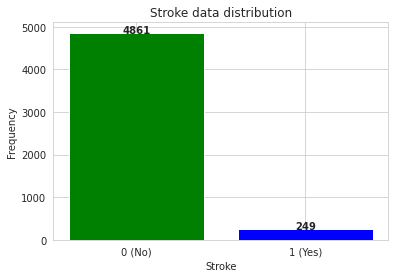

In [8]:
sns.set_style('whitegrid')
x1 = [u'0 (No)', u'1 (Yes)']
y1 = [df[df.stroke == 0].stroke.count(), df[df.stroke == 1].stroke.count()]
New_Colors = ['green','blue']
create_barplot(x1, y1, New_Colors, 'Stroke', 'Frequency', 'Stroke data distribution')

In [9]:
df.drop([3116], inplace = True)

In [10]:
y = df['stroke']
X = df.drop('stroke',axis=1)

## 1. EDA (Data Analysis & Visualisation)

### 1.1 Gender

In [11]:
df[df.gender == 'Male'].gender.count()

2115

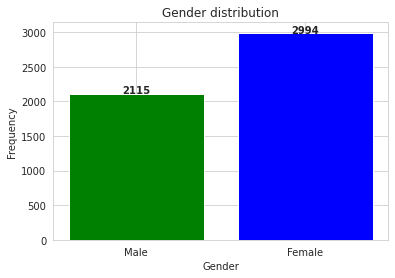

In [12]:
#histogram
sns.set_style('whitegrid')
x1 = [u'Male', u'Female']
y1 = [df[df.gender == 'Male'].gender.count(), df[df.gender == 'Female'].gender.count()]
New_Colors = ['green','blue']



create_barplot(x1, y1, New_Colors, 'Gender', 'Frequency', 'Gender distribution')

### 1.2 Age

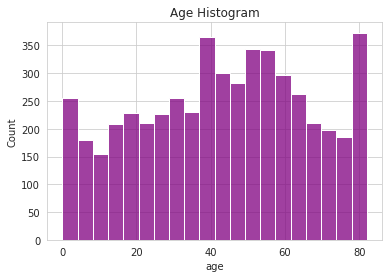

In [13]:
sns.histplot(data = df, x = "age", color='purple')
plt.title('Age Histogram')
plt.show()

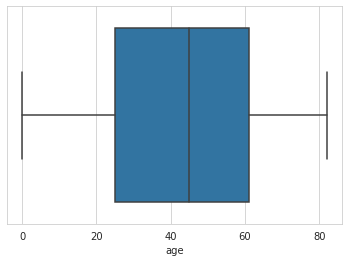

In [14]:
sns.boxplot(x = df['age'])

### 1.3 Hypertension

In [15]:
df.hypertension.unique()

array([0, 1])

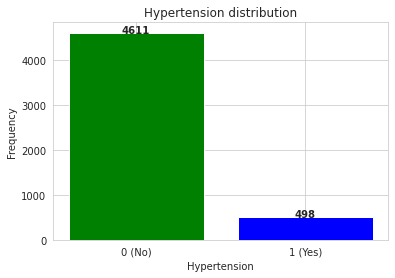

In [16]:
x1 = [u'0 (No)', u'1 (Yes)']
y1 = [df[df.hypertension == 0].hypertension.count(), df[df.hypertension == 1].hypertension.count()]
New_Colors = ['green', 'blue']

create_barplot(x1, y1, New_Colors, 'Hypertension', 'Frequency', 'Hypertension distribution')

### 1.4 Heart Disease

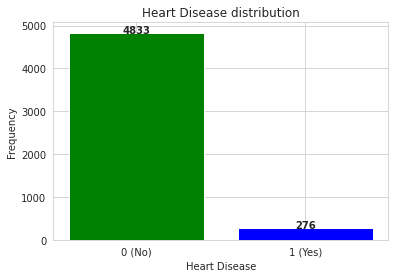

In [17]:
x1 = [u'0 (No)', u'1 (Yes)']
y1 = [df[df.heart_disease == 0].heart_disease.count(), df[df.heart_disease == 1].heart_disease.count()]
New_Colors = ['green', 'blue']

create_barplot(x1, y1, New_Colors, 'Heart Disease', 'Frequency', 'Heart Disease distribution')

### 1.5 Ever Married

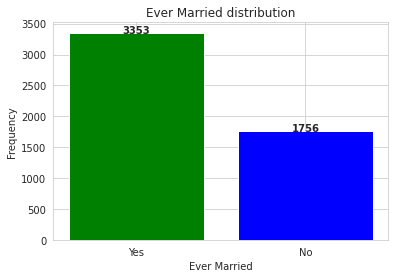

In [18]:
x1 = [u'Yes', u'No']
y1 = [df[df.ever_married == 'Yes'].ever_married.count(), df[df.ever_married == 'No'].ever_married.count()]
New_Colors = ['green', 'blue']

create_barplot(x1, y1, New_Colors, 'Ever Married', 'Frequency', 'Ever Married distribution')

### 1.6 Work Type

In [19]:
df.work_type.value_counts()[:]

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

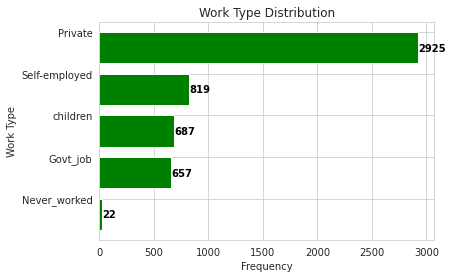

In [20]:
def create_barhplot(x, y, colors, labelx, labely, title): 
  fig, ax = plt.subplots()    
  width = 0.75 # the width of the bars 
  ind = np.arange(len(y))  # the x locations for the groups
  ax.barh(ind, y, width, color=colors)
  ax.set_yticks(ind+width/2)
  ax.set_yticklabels(x, minor=False)
  plt.title(title)
  plt.xlabel(labelx)
  plt.ylabel(labely)
  for i, v in enumerate(y):
    ax.text(v + 4, i, str(v), color='black', fontweight='bold', va='center')


x1 = [u'Never_worked', u'Govt_job', u'children', u'Self-employed',u'Private']
y1 = [22, 657, 687, 819, 2925]
create_barhplot(x1, y1, 'green', 'Frequency', 'Work Type', 'Work Type Distribution')

### 1.7 Residence Type

In [21]:
df.Residence_type.value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

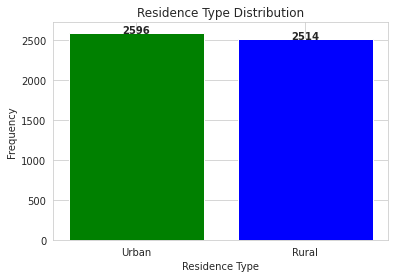

In [22]:
x1 = [u'Urban', u'Rural']
y1 = [2596, 2514]
colors = ['green', 'blue']
create_barplot(x1, y1, colors, 'Residence Type', 'Frequency', 'Residence Type Distribution')

### 1.8 Average Glucose Level

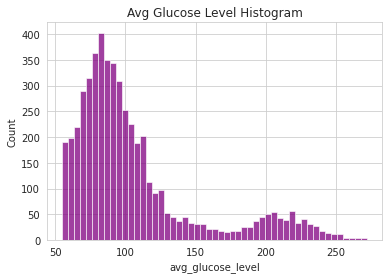

In [23]:
sns.histplot(data = df, x = "avg_glucose_level", color='purple')
plt.title('Avg Glucose Level Histogram')
plt.show()

### 1.9 BMI

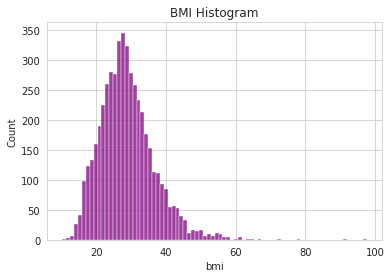

In [24]:
sns.histplot(data = df, x = "bmi", color='purple')
plt.title('BMI Histogram')
plt.show()

### 1.10 Smoking Status

In [25]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

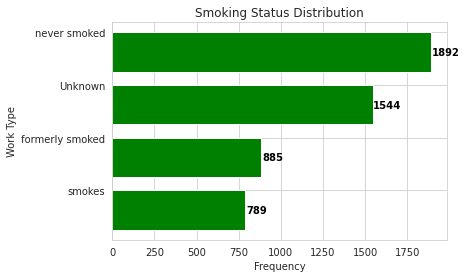

In [26]:
x1 = [u'smokes', u'formerly smoked', u'Unknown', u'never smoked']
y1 = [789, 885, 1544, 1892]
create_barhplot(x1, y1, 'green','Frequency','Work Type', 'Smoking Status Distribution')

## 2. Data Processing

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3423, 11), (1686, 11), (3423,), (1686,))

In [28]:
X_train['bmi'].fillna(X_train['bmi'].median(),inplace=True)
X_test['bmi'].fillna(X_test['bmi'].median(),inplace=True)

### 2.1 Feature Transformation

#### BMI

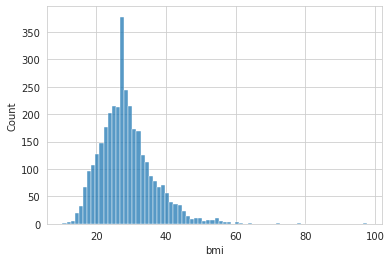

In [29]:
sns.histplot(data = X_train, x = 'bmi')

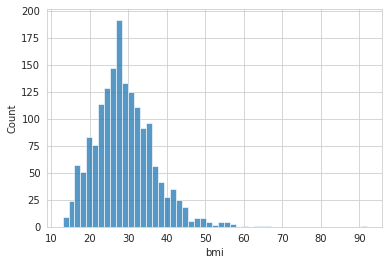

In [30]:
sns.histplot(data = X_test, x = 'bmi')

In [31]:
X_train['bmi'] = np.log(X_train['bmi'])
X_test['bmi'] = np.log(X_test['bmi'])

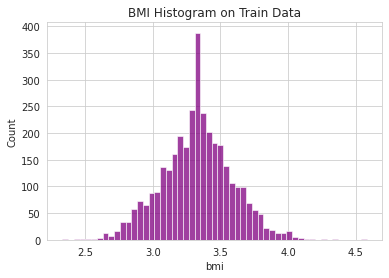

In [32]:
sns.histplot(data = X_train, x = "bmi", color='purple')
plt.title('BMI Histogram on Train Data')
plt.show()

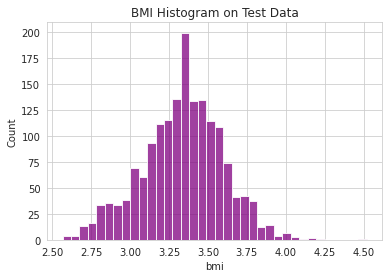

In [33]:
sns.histplot(data = X_test, x = "bmi", color='purple')
plt.title('BMI Histogram on Test Data')
plt.show()

#### Average Glucose Level

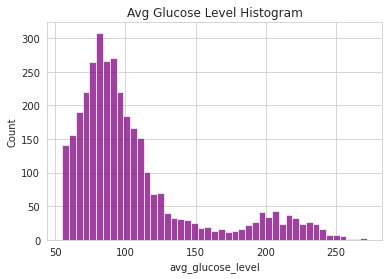

In [34]:
sns.histplot(data = X_train, x = "avg_glucose_level", color='purple')
plt.title('Avg Glucose Level Histogram')
plt.show()

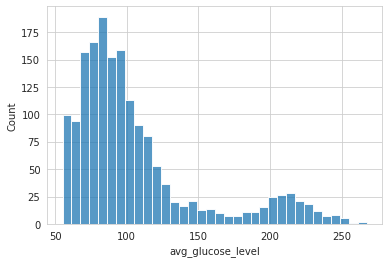

In [35]:
sns.histplot(data = X_test, x = 'avg_glucose_level')

In [36]:
X_train['avg_glucose_level'] = 1 / X_train['avg_glucose_level']
X_test['avg_glucose_level'] = 1 / X_test['avg_glucose_level']

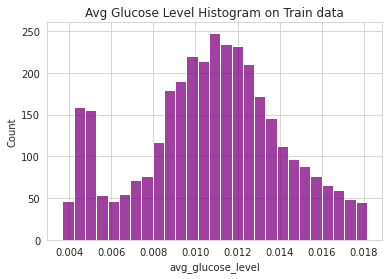

In [37]:
sns.histplot(data = X_train, x = "avg_glucose_level", color='purple')
plt.title('Avg Glucose Level Histogram on Train data')
plt.show()

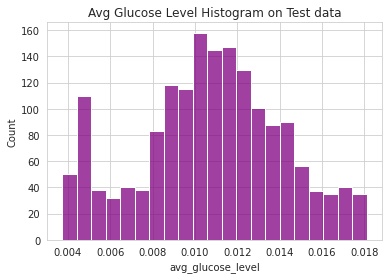

In [38]:
sns.histplot(data = X_test, x = "avg_glucose_level", color='purple')
plt.title('Avg Glucose Level Histogram on Test data')
plt.show()

In [39]:
X = pd.concat([X_train, y_train], axis = 1)
stroke = X[X['stroke'] == 1]
not_stroke = X[X['stroke'] == 0]

### 2.2 Without Resampling

In [ ]:
x1 = [u'Urban', u'Rural']
y1 = [2596, 2514]
colors = ['green', 'blue']
create_barplot(x1, y1, colors, 'Residence Type', 'Frequency', 'Residence Type Distribution')

In [ ]:
X_train_w = X_train.copy()
y_train_w = y_train.copy()

X_test_w = X_test.copy()
y_test_w = y_test.copy()

In [ ]:
# Normalization of numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_w[['age','avg_glucose_level','bmi']] = scaler.fit_transform(X_train_w[['age','avg_glucose_level','bmi']])
X_test_w[['age','avg_glucose_level','bmi']] = scaler.fit_transform(X_test_w[['age','avg_glucose_level','bmi']])

In [ ]:
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape

((3423, 11), (1686, 11), (3423,), (1686,))

In [ ]:
# Drop id column
X_train_w.drop('id',axis=1,inplace=True) 
X_test_w.drop('id',axis=1,inplace=True)

In [ ]:
X_train_w, X_test_w = one_hot_encoding(X_train_w, X_test_w, ['gender', 'ever_married', 'work_type', 'Residence_type', 
                                                     'smoking_status'])

In [ ]:
X_train_w.drop(['gender_2', 'ever_married_2', 'work_type_5', 'Residence_type_2', 'smoking_status_4', 
             'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1, inplace = True)
X_test_w.drop(['gender_2', 'ever_married_2', 'work_type_5', 'Residence_type_2', 'smoking_status_4', 
             'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1, inplace = True)

In [ ]:
X_train_w['target'] = y_train_w
X_test_w = np.array(X_test_w)
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test.shape

((3423, 16), (1686, 15), (3423,), (1686,))

In [ ]:
from sklearn import metrics 
from sklearn.model_selection import KFold
learning_rate = 0.03
n_hidden = 8 # Banyaknya neuron pada hidden layer

## Find the highest accuracy
NN = NeuralNetwork()
list_epoch = [100, 250, 500, 750, 1000]
train_scores = []
test_scores = []

n_inputs = len(train[0]) - 1 # Banyaknya fitur tanpa fitur target
n_outputs = len(set([row[-1] for row in train])) # banyaknya jenis kemungkinan output

NN = NeuralNetwork()
NN.initialize_network(n_inputs, n_hidden, n_outputs)

for epoch in list_epoch:
  NN.train_network(train, learning_rate, epoch, n_outputs)
  # evaluate on the train dataset
  yhat1 = NN.back_propagation(np.array(X_train_w)) # bagian ini jangan lupa diupdate 
  yhat2 = NN.back_propagation(np.array(X_test_w))
  train_acc = accuracy_score(y_train_w, yhat1)
  test_acc = accuracy_score(y_test_w, yhat2)
  train_scores.append(train_acc)
  test_scores.append(test_acc)
  print("Epoch =",epoch,"==>","Train score :",train_acc, ",", "Test score :", test_acc)
print("======================================================================")

NameError: ignored

In [ ]:
plt.plot(list_epoch, train_scores, '-o', label='Train')
plt.plot(list_epoch, test_scores, '-o', label='Test')
plt.legend()
plt.show()

### Oversampling

In [40]:
from sklearn.utils import resample

stroke_upsampled = resample(stroke,
                          replace = True, # sample with replacement
                          n_samples = len(not_stroke), # match number in majority class
                          random_state = 27) # reproducible results

In [41]:
upsampled = pd.concat([not_stroke, stroke_upsampled])

In [42]:
upsampled['stroke'].value_counts()

1    3251
0    3251
Name: stroke, dtype: int64

In [43]:
y_train_oversampling = upsampled['stroke']
X_train_oversampling = upsampled.drop(['stroke'], axis = 1)

y_test_oversampling = y_test.copy()
X_test_oversampling = X_test.copy()

In [44]:
X_train_oversampling.shape, X_test_oversampling.shape, y_train_oversampling.shape, y_test_oversampling.shape

((6502, 11), (1686, 11), (6502,), (1686,))

In [45]:
# Normalization of numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_oversampling[['age','avg_glucose_level','bmi']] = scaler.fit_transform(X_train_oversampling[['age','avg_glucose_level','bmi']])
X_test_oversampling[['age','avg_glucose_level','bmi']] = scaler.fit_transform(X_test_oversampling[['age','avg_glucose_level','bmi']])

In [46]:
X_train_oversampling.shape, X_test_oversampling.shape, y_train_oversampling.shape, y_test_oversampling.shape

((6502, 11), (1686, 11), (6502,), (1686,))

In [47]:
# Drop id column
X_train_oversampling.drop('id',axis=1,inplace=True) 
X_test_oversampling.drop('id',axis=1,inplace=True)

In [48]:
X_train_oversampling, X_test_oversampling = one_hot_encoding(X_train_oversampling, X_test_oversampling, ['gender', 'ever_married', 'work_type', 'Residence_type', 
                                                     'smoking_status'])

In [49]:
X_train_oversampling.drop(['gender_2', 'ever_married_2', 'work_type_5', 'Residence_type_2', 'smoking_status_4', 
             'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1, inplace = True)
X_test_oversampling.drop(['gender_2', 'ever_married_2', 'work_type_5', 'Residence_type_2', 'smoking_status_4', 
             'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1, inplace = True)

In [50]:
X_train_oversampling['target'] = y_train_oversampling
X_test_oversampling = np.array(X_test_oversampling)
X_train_oversampling.shape, X_test_oversampling.shape, y_train_oversampling.shape, y_test_oversampling.shape

((6502, 16), (1686, 15), (6502,), (1686,))

In [ ]:
from sklearn import metrics 
from sklearn.model_selection import KFold
learning_rate = 0.03
n_hidden = 8 # Banyaknya neuron pada hidden layer

## Find the highest accuracy
NN = NeuralNetwork()
list_epoch = [100, 250, 500, 750, 1000]
train_scores = []
test_scores = []

n_inputs = len(train[0]) - 1 # Banyaknya fitur tanpa fitur target
n_outputs = len(set([row[-1] for row in train])) # banyaknya jenis kemungkinan output

NN = NeuralNetwork()
NN.initialize_network(n_inputs, n_hidden, n_outputs)

for epoch in list_epoch:
  NN.train_network(train, learning_rate, epoch, n_outputs)
  # evaluate on the train dataset
  yhat1 = NN.back_propagation(np.array(X_train_oversampling)) # bagian ini jangan lupa diupdate 
  yhat2 = NN.back_propagation(np.array(X_test_oversampling))
  train_acc = accuracy_score(y_train_oversampling, yhat1)
  test_acc = accuracy_score(y_test_oversampling, yhat2)
  train_scores.append(train_acc)
  test_scores.append(test_acc)
  print("Epoch =",epoch,"==>","Train score :",train_acc, ",", "Test score :", test_acc)
print("======================================================================")

NameError: ignored

In [ ]:
plt.plot(list_epoch, train_scores, '-o', label='Train')
plt.plot(list_epoch, test_scores, '-o', label='Test')
plt.legend()
plt.show()

### Undersampling

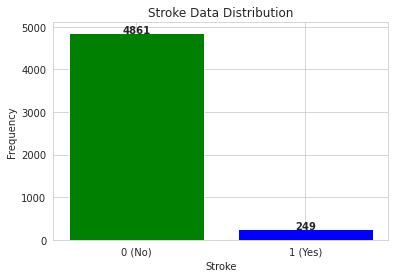

In [ ]:
x1 = [u'0 (No)', u'1 (Yes)']
y1 = [4861, 249]
colors = ['green', 'blue']
create_barplot(x1, y1, colors, 'Stroke', 'Frequency', 'Stroke Data Distribution')

In [ ]:
from sklearn.utils import resample
not_stroke_downsampled = resample(not_stroke,
                                replace = False, # sample without replacement
                                n_samples = len(stroke), # match minority n
                                random_state = 27) # reproducible results

In [ ]:
downsampled = pd.concat([not_stroke_downsampled, stroke])

In [ ]:
downsampled['stroke'].value_counts()

1    172
0    172
Name: stroke, dtype: int64

In [ ]:
y_train_undersampling = downsampled['stroke']
X_train_undersampling = downsampled.drop(['stroke'], axis = 1)

y_test_undersampling = y_test.copy()
X_test_undersampling = X_test.copy()

In [ ]:
X_train_undersampling, X_test_undersampling = one_hot_encoding(X_train_undersampling, X_test_undersampling, ['gender', 'ever_married', 'work_type', 'Residence_type', 
                                                     'smoking_status'])

In [ ]:
X_train_undersampling.drop(['gender_2', 'ever_married_2', 'work_type_5', 'Residence_type_2', 'smoking_status_4', 
             'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1, inplace = True)
X_test_undersampling.drop(['gender_2', 'ever_married_2', 'work_type_5', 'Residence_type_2', 'smoking_status_4', 
             'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1, inplace = True)

In [ ]:
# Drop id column
X_train_undersampling.drop('id',axis=1,inplace=True) 
X_test_undersampling.drop('id',axis=1,inplace=True)

In [ ]:
X_train_undersampling.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_1', 'ever_married_1', 'work_type_1', 'work_type_2',
       'work_type_3', 'work_type_4', 'Residence_type_1', 'smoking_status_1',
       'smoking_status_2', 'smoking_status_3'],
      dtype='object')

In [ ]:
X_train_undersampling.shape, X_test_undersampling.shape, y_train_undersampling.shape, y_test_undersampling.shape

((344, 15), (1686, 15), (344,), (1686,))

In [ ]:
# Normalization of numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_undersampling[['age','avg_glucose_level','bmi']] = scaler.fit_transform(X_train_undersampling[['age','avg_glucose_level','bmi']])
X_test_undersampling[['age','avg_glucose_level','bmi']] = scaler.fit_transform(X_test_undersampling[['age','avg_glucose_level','bmi']])

In [ ]:
X_train_undersampling.shape, X_test_undersampling.shape, y_train_undersampling.shape, y_test_undersampling.shape

((344, 15), (1686, 15), (344,), (1686,))

In [ ]:
X_train_undersampling['target'] = y_train_undersampling
train = np.array(X_train_undersampling)
X_test = np.array(X_test_undersampling)
train.shape, X_test.shape, y_train_undersampling.shape, y_test.shape

((344, 16), (1686, 15), (344,), (1686,))

In [ ]:
y_train_undersampling.value_counts()

1    172
0    172
Name: stroke, dtype: int64

In [53]:
X_train_oversampling['target'] = y_train_oversampling
train = np.array(X_train_oversampling)
X_test_oversampling = np.array(X_test_oversampling)
X_train_oversampling.shape, X_test_oversampling.shape, y_train_oversampling.shape, y_test_oversampling.shape

((6502, 16), (1686, 15), (6502,), (1686,))

In [ ]:
from sklearn import metrics 
from sklearn.model_selection import KFold
learning_rate = 0.05
epoch = 1000 # Banyaknya neuron pada hidden layer

## Find the highest accuracy
NN = NeuralNetwork()
list_epoch = [100, 250, 500, 750]
train_scores = []
test_scores = []

n_inputs = len(train[0]) - 1 # Banyaknya fitur tanpa fitur target
n_outputs = len(set([row[-1] for row in train])) # banyaknya jenis kemungkinan output

list_neurons = list(range(1, 16))

for epoch in list_epoch:
  max_train = 0
  max_test = 0
  best_epoch = 0
  best_neuron = 0
  for neurons in range(1, 16):
    NN = NeuralNetwork()
    NN.initialize_network(n_inputs, neurons, n_outputs)
    NN.train_network(train, learning_rate, epoch, n_outputs)
    # evaluate on the train dataset
    yhat1 = NN.back_propagation(np.array(X_train_oversampling)) # bagian ini jangan lupa diupdate 
    yhat2 = NN.back_propagation(np.array(X_test_oversampling))
    train_acc = accuracy_score(y_train_oversampling, yhat1)
    test_acc = accuracy_score(y_test_oversampling, yhat2)
    if train_acc > max_train and test_acc > max_test:
      max_train = train_acc
      max_test = test_acc
      best_epoch = epoch
      best_neuron = neurons
  print("For Epoch =",best_epoch,", Best Neuron =",best_neuron,"==>","Train score :",max_train, ",", "Test score :", max_test)
  print("======================================================================")

For Epoch = 100 , Best Neuron = 10 ==> Train score : 0.617348508151338 , Test score : 0.28291814946619215
For Epoch = 250 , Best Neuron = 14 ==> Train score : 0.6550292217779144 , Test score : 0.35587188612099646


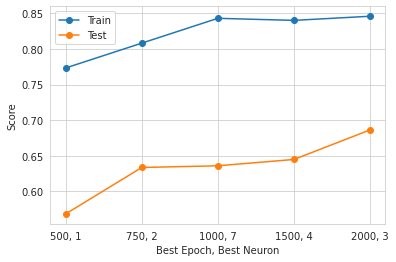

In [ ]:
list_neurons = ["500, 1", "750, 2", "1000, 7", "1500, 4", "2000, 3"]
train_scores = [0.77326,0.80814,0.84302,0.84012,0.84593]
test_scores = [0.56821,0.63345,0.63582,0.64472,0.68624]
plt.plot(list_neurons, train_scores, '-o', label='Train')
plt.plot(list_neurons, test_scores, '-o', label='Test')
plt.xlabel("Best Epoch, Best Neuron")
plt.ylabel("Score")
plt.legend()
plt.show()

In [ ]:
X_test_undersampling

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_1,ever_married_1,work_type_1,work_type_2,work_type_3,work_type_4,Residence_type_1,smoking_status_1,smoking_status_2,smoking_status_3
42,1.000000,0,1,0.220178,0.362020,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
380,0.046921,0,0,0.395032,0.127992,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1559,0.645650,0,0,0.697969,0.836427,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
352,0.242424,0,0,0.460487,0.492809,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3639,0.621212,1,0,0.550548,0.457123,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,0.376833,0,0,0.679599,0.354218,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1984,0.621212,0,1,0.464313,0.432431,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1047,0.059140,0,0,0.559232,0.154816,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4382,0.193548,0,0,0.391475,0.240185,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
# Example of a confusion matrix in Python
learning_rate = 0.05
n_hidden = 3 # Banyaknya neuron pada hidden layer
n_inputs = len(train[0]) - 1 # Banyaknya fitur tanpa fitur target
epoch = 2000
n_outputs = len(set([row[-1] for row in train])) # banyaknya jenis kemungkinan output
X_train_undersampling['target'] = y_train_undersampling
train = np.array(X_train_undersampling)
X_test = np.array(X_test_undersampling)

NN = NeuralNetwork()
NN.initialize_network(n_inputs, n_hidden, n_outputs)
NN.train_network(train, learning_rate, epoch, n_outputs)
yhat = NN.back_propagation(np.array(X_test))

>epoch=0, lrate=0.050, error=161.852
>epoch=1, lrate=0.050, error=142.768
>epoch=2, lrate=0.050, error=146.190
>epoch=3, lrate=0.050, error=146.383
>epoch=4, lrate=0.050, error=146.344
>epoch=5, lrate=0.050, error=146.292
>epoch=6, lrate=0.050, error=146.243
>epoch=7, lrate=0.050, error=146.197
>epoch=8, lrate=0.050, error=146.153
>epoch=9, lrate=0.050, error=146.112
>epoch=10, lrate=0.050, error=146.073
>epoch=11, lrate=0.050, error=146.036
>epoch=12, lrate=0.050, error=146.001
>epoch=13, lrate=0.050, error=145.966
>epoch=14, lrate=0.050, error=145.933
>epoch=15, lrate=0.050, error=145.901
>epoch=16, lrate=0.050, error=145.870
>epoch=17, lrate=0.050, error=145.838
>epoch=18, lrate=0.050, error=145.807
>epoch=19, lrate=0.050, error=145.776
>epoch=20, lrate=0.050, error=145.745
>epoch=21, lrate=0.050, error=145.713
>epoch=22, lrate=0.050, error=145.680
>epoch=23, lrate=0.050, error=145.646
>epoch=24, lrate=0.050, error=145.610
>epoch=25, lrate=0.050, error=145.571
>epoch=26, lrate=0.050

In [ ]:
accuracy_score(y_test_undersampling, yhat)

0.6583629893238434

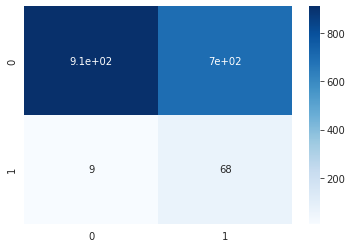

In [ ]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
n_inputs = len(train[0]) - 1 # Banyaknya fitur tanpa fitur target
n_outputs = len(set([row[-1] for row in train])) # banyaknya jenis kemungkinan output
NN = NeuralNetwork()
NN.initialize_network(n_inputs, 3, n_outputs)
NN.train_network(train, learning_rate, 2000, n_outputs)
yhat = NN.back_propagation(np.array(X_test_undersampling))
matrix = confusion_matrix(y_test_undersampling, yhat)
sns.heatmap(matrix, cmap='Blues', annot=True)
plt.show()